# Static maps

Creating static maps is an integral part of any geographic data analysis process. Visualizing geographic information as maps is useful not only as an end result for communicating the results but also during the data analysis process for data exploration and visual analysis. Static maps can be exported to various image formats and integrated, for example, in reports and scientific articles just like any other figures. In this section, we will practice plotting static maps using sample data from Helsinki, Finland. 

[Mapping tools in `geopandas`](https://geopandas.org/en/stable/docs/user_guide/mapping.html) [^geopandas_mappingtools] allow creating simple static maps easily. In the background, `geopandas` uses `matplotlib` for creating the plots and we can use [`matplotlib.pyplot`](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html) [^matplotlib_pyplot] tools for further customizing our figures. We will also learn how to use `contextily` for adding basemaps.

## Plotting a simple map with multiple layers

 Let's start by importing the required modules and defining our data sources. We will visualize information about travel times across the region from the Helsinki Region Travel Time Matrix dataset ({cite}`Tenkanen2020`). In addition, we can add additional spatial context to the map through adding information about the transport network using [open data from Helsinki Region Transport](https://www.avoindata.fi/data/en_GB/dataset/hsl-n-linjat) [^HSL_opendata].


In [1]:
from pathlib import Path
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

data_dir = Path("../data")
grid_fp = data_dir / "TravelTimes_to_5975375_RailwayStation.shp"
transport_fp = data_dir / "HSL%3An_linjat.zip"

# Read files
grid = gpd.read_file(grid_fp)
transport = gpd.read_file(transport_fp)

# Filtering out some useful transport features for our map
metro = transport.loc[transport["JL_LAJI"] == "06"]
train = transport.loc[transport["JL_LAJI"] == "12"]

The travel time data contains multiple columns with information on travel times and distances from each statistical grid square to the central railway station in Helsinki. See Table 3 in {cite}`Tenkanen2020` for detailed description of each column. Here, we will use the column `'pt_r_t'` which contains information about travel time in minutes to the central railway station by public transportation in rush hour traffic.

In [2]:
grid.columns

Index(['car_m_d', 'car_m_t', 'car_r_d', 'car_r_t', 'from_id', 'pt_m_d',
       'pt_m_t', 'pt_m_tt', 'pt_r_d', 'pt_r_t', 'pt_r_tt', 'to_id', 'walk_d',
       'walk_t', 'geometry'],
      dtype='object')

The NoData values in the data are presented with value -1. Let's set the nodata values as `NaN` before proceeding:

In [3]:
grid = grid.replace(-1, np.nan)

Now we can use `geopandas` for visualizing a simple map representing the rush hour public transport travel times (`'pt_r_t'`) for our map. We can speficy the column that we want to visualize through the `plot()` method parameters to get a color gradient representing the column values:

<Axes: >

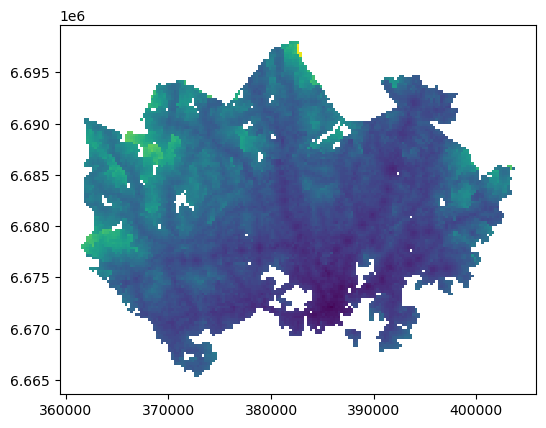

In [4]:
grid.plot(column="pt_r_t")

What we have here is a `choropleth map` where the colors of each grid square polygon are based on values from the column `pt_r_t`. We will see later how to change the classification scheme that determines the assignment of values to each class for the visualization. 

The power of geographic information often relies on overlaying multiple features and exploring their spatial relations. Here, we can visualize the transport network data on top of the travel time information to add spatial context in our map. In order to plot multiple layers in the same figure, the first thing is to check the coordinate reference system (CRS) of the data to check that they match:

In [5]:
# Check the crs of each layer
print(grid.crs)
print(metro.crs)
print(train.crs)

EPSG:3067
EPSG:4326
EPSG:4326


All layers have a defined CRS, but we can see that the coordinate reference system definitions don't match, which is a problem for plotting our map. The grid is in ETRS89 / TM35FIN (EPSG:3067), which is an appropriate map projection for visualizing data from Finland. Roads and the metro are in WGS 84 (EPSG:4326) meaning that the coordinates are in latitudes and longitudes. Let's see what happens if trying to plot all three layers in the same figure without re-projecting the data:

<Axes: >

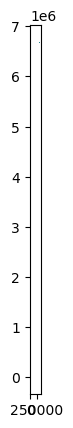

In [6]:
ax = grid.plot(column="pt_r_t")
train.plot(ax=ax, color="brown")
metro.plot(ax=ax, color="red")
train.plot(ax=ax)

We need to re-project the data in order to get the layers in the same coordinate space. Here, we can re-project the linear features (train and metro) from WGS 84 to ETRS89 / TM35FIN (EPSG:3067). While doing this, we can get the crs definition based on the grid layer ensuring that the crs definitions will be identical.

In [7]:
# Reproject geometries to ETRS89 / TM35FIN based on the grid crs:
train = train.to_crs(crs=grid.crs)
metro = metro.to_crs(crs=grid.crs)

Now the layers should be in the same coordinate reference system:

In [8]:
# Check the crs of each layer
print(grid.crs)
print(metro.crs)
print(train.crs)

EPSG:3067
EPSG:3067
EPSG:3067


Once the data are in the same projection, we can plot them on a map. First, we plot one of the layers and store that plot object in the variable `ax` (referring to the subplot object) and use this for plotting the other layers in the same subplot:

<Axes: >

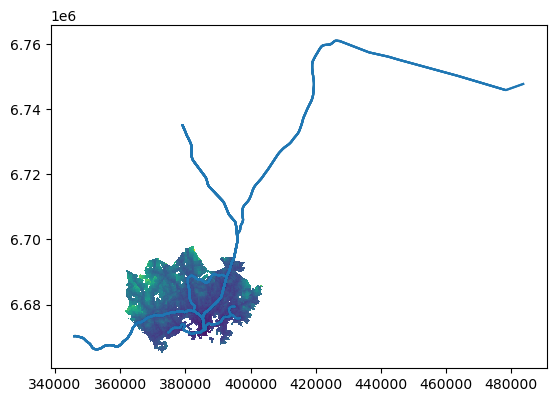

In [9]:
ax = grid.plot(column="pt_r_t")
train.plot(ax=ax)
metro.plot(ax=ax)

Now our layers are nicely aligned, but the map needs some further improvement regarding the layout. For better control of the plot features, we can start using `matplotlib.pyplot`. Some map elements such as color and linewidth are still easy to configure directly when plotting data via `geopandas`, but we need `matplotlib` for controlling other features related to the layout. Let's apply the following changes to our plot: 

- Changing the colors of the choropleth map using the `cmap` parameter. See available [colormap options from matplotlib documentation](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html#choosing-colormaps-in-matplotlib) [^matplotlib_colormaps].
- Adding a legend and a label for the legend. You can read more info about adjusting legends in [`geopandas` mapping tutorial](https://geopandas.org/en/stable/docs/user_guide/mapping.html) [^geopandas_mappingtools] and in the [`matplotlib` legend guide](https://matplotlib.org/tutorials/intermediate/legend_guide.html) [^matplotlib_legend].
- Changing line colors using the `color` parameter. See [color options from matplotlib pyplot documentation](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.colors) [^matplotlib_colors].
- Changing the `linewidth` of line features.
- Adding transparency using the `alpha` parameter (this parameter ranges from 0 to 1 where 0 is fully transparent).
- Cropping the figure by adjusting the view limit of each axis via `matplotlib`. We can get the desired plot extent from the `total_bounds` of the grid layer. This way we don't need to separately crop the train line that goes outside the extent of the grid data.
- Using a `tight_layout`to adjust the subplot to fit in the figure area via `matplotlib`.
- Removing the frame and and axis labels through setting x- and y- axis on or off via `matplotlib`.

Finally, we can save the figure as PNG image.

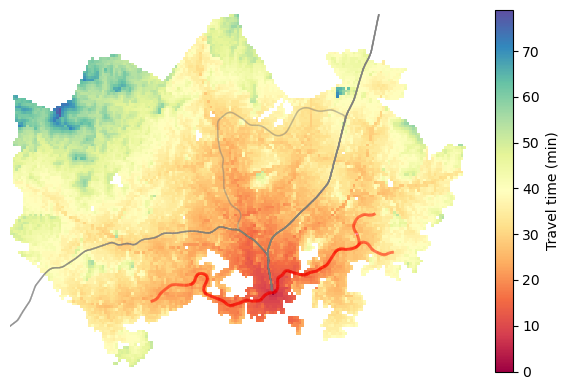

In [10]:
# Create one subplot. Control figure size in here.
fig, ax = plt.subplots(figsize=(6, 4))

# Visualize the travel times
grid.plot(ax=ax, 
          column="car_r_t", 
          cmap="Spectral", 
          legend=True,
         legend_kwds={"label": "Travel time (min)"})

# Add roads on top of the grid
# (use ax parameter to plot this layer into the same subplot as the previous layer)
train.plot(ax=ax, color="grey", linewidth=1, alpha=0.1)

# Add metro on top of the previous map
metro.plot(ax=ax, color="red", linewidth=2, alpha=0.1)

# Set axis view limits based on the total bounds of the grid layer
ax.set_xlim(grid.total_bounds[0], grid.total_bounds[2])
ax.set_ylim(grid.total_bounds[1], grid.total_bounds[3])

# Set the x and y axis off 
plt.axis("off")

# Adjust padding around the subplot
plt.tight_layout()

# Save the figure as png file with resolution of 300 dpi
outfp = "static_map.png"
plt.savefig(outfp, dpi=300)

## Classification schemes

With choropleth maps, it is essential to pay attention to the classification scheme that is used to display the values. We will now learn how to use classification schemes from the [PySAL](https://pysal.org/) [mapclassify library](https://pysal.org/mapclassify/) [^mapclassify] to classify quantitative data into multiple classes for visualization purposes. These classification schemes can be used directly when plotting data in `geopandas` as long as `mapclassify` package is also installed.  Available classification schemes include:

 - Box_Plot
 - Equal_Interval
 - Fisher_Jenks
 - Fisher_Jenks_Sampled
 - HeadTail_Breaks
 - Jenks_Caspall
 - Jenks_Caspall_Forced
 - Jenks_Caspall_Sampled
 - Max_P_Classifier
 - Maximum_Breaks
 - Natural_Breaks
 - Quantiles
 - Percentiles
 - Std_Mean
 - User_Defined

 Each classification scheme partitions the data into mutually exclusive groups that define how the values are displayed on the map. See {cite}`Rey_et_al_2023` for a thorough introduction on the mathematics behind each classification scheme. Choosing an adequate classification scheme and number of classes depends on the message we want to convey with our map and the underlying distribution of the data. When visualizing travel times on a map we want our map to show regional differences in the travel times in an intuitive way.

Let's have a closer look at how these `mapclassify` classifiers work and try out different classification schemes for visualizing the public transport traveltimes. For  a closer look of the classifiers, let's create a `pandas` `Series` without `NaN` values. 

In [11]:
import mapclassify

# Getting a data Series withouth NaN values
travel_times = grid.loc[grid["pt_r_t"].notnull(), "pt_r_t"]

- Natural Breaks 

In [12]:
mapclassify.NaturalBreaks(y=travel_times, k=6)

NaturalBreaks

    Interval       Count
------------------------
[  0.00,  30.00] |  1406
( 30.00,  44.00] |  3813
( 44.00,  57.00] |  3107
( 57.00,  72.00] |  2480
( 72.00,  94.00] |  1596
( 94.00, 181.00] |   618

- Quantiles (default is 5 classes):

In [13]:
mapclassify.Quantiles(y=travel_times, k=6)

Quantiles

    Interval       Count
------------------------
[  0.00,  34.00] |  2293
( 34.00,  41.00] |  2086
( 41.00,  49.00] |  2159
( 49.00,  59.00] |  2161
( 59.00,  73.00] |  2234
( 73.00, 181.00] |  2087

It's possible to extract the threshold values into an array:

In [14]:
mapclassify.NaturalBreaks(y=travel_times, k=9).bins

array([ 24.,  35.,  44.,  54.,  65.,  76.,  90., 109., 181.])

Let's have a look at the distribution of the public transport travel times through checking the histogram and descriptive statistics. A histogram is a graphic representation of the distribution of the data. Descriptive statistics summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding `NaN` values.

<Axes: ylabel='Frequency'>

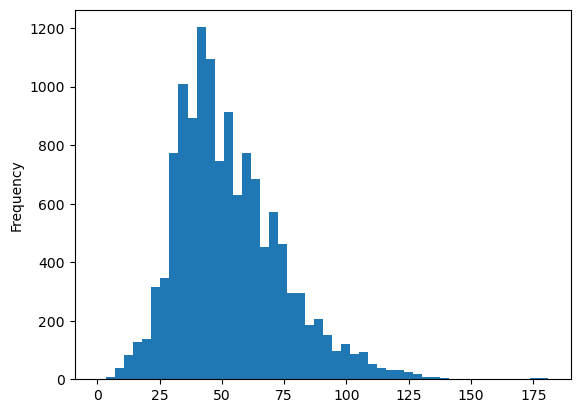

In [15]:
travel_times.plot.hist(bins=50)

In [16]:
travel_times.describe()

count    13020.000000
mean        53.124654
std         21.295944
min          0.000000
25%         38.000000
50%         49.000000
75%         65.000000
max        181.000000
Name: pt_r_t, dtype: float64

The mamximum travel time to the central railway station by public transport (including time for walking) is 181 minutes, i.e. over three hours. most of the travel times range between 38 and 65 minutes with an average travel time of around 50 minutes. Note, that this data covers all statistical grid squares in the city region and not only inhabited grid squares for which the distribution of the data would likely be different with shorter travel times to the central railway station. As a public transport travel time longer than two hours is not a realistic choise for someone doing their daily commute in the Helsinki region. Based on this information, we might want our map to show differences in the shorter travel times, but we are happy if the longer travel times are grouped into one class in our map visualization. 

Let's see how some of the `mapclassify` classifiers would classify our travel time values. In the interactive version of this book, you can try out different numbers of classes and classification schemes. Here we demonstrate:
- Natural breaks:

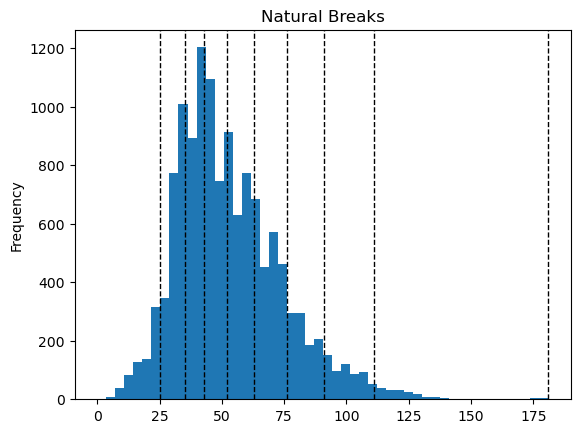

In [17]:
import matplotlib.pyplot as plt

# Define classifier
classifier = mapclassify.NaturalBreaks(y=travel_times, k=9)

# Plot histogram for public transport rush hour travel time
grid["pt_r_t"].plot.hist(bins=50, title="Natural Breaks")

# Add vertical lines for class breaks
for break_point in classifier.bins:
    plt.axvline(break_point, color="k", linestyle="dashed", linewidth=1)

- Quantiles:

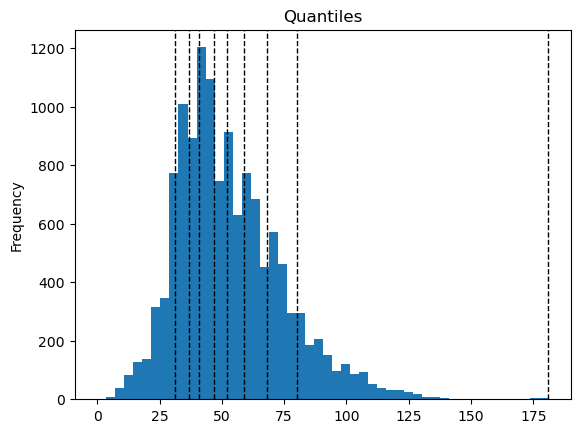

In [18]:
import matplotlib.pyplot as plt

# Define classifier
classifier = mapclassify.Quantiles(y=travel_times, k=9)

# Plot histogram for public transport rush hour travel time
grid["pt_r_t"].plot.hist(bins=50, title="Quantiles")

# Add vertical lines for class breaks
for break_point in classifier.bins:
    plt.axvline(break_point, color="k", linestyle="dashed", linewidth=1)

# Using the classification schemes for visualizing maps

We can continue exploring the available classification schemes on a map through adding the `scheme` option, while the parameter `k` defines the number of classess to use. Note that the syntax via `geopandas` differs a bit from `mapclassify`. We can control the position and title of the legend using `matplotlib` tools trough changing the properties of the legend object. It is easy to add a label for the legend using `legend_kwds`. You can read more about creating a legend via geopandas [in here](https://geopandas.org/mapping.html#creating-a-legend).

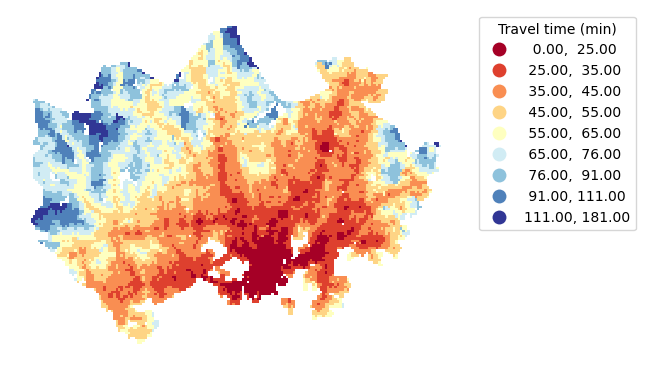

In [19]:
# Plot using 9 classes and classify the values using "Natural Breaks" classification
ax = grid.plot(
    figsize=(6, 4),
    column="pt_r_t",
    cmap="RdYlBu",
    linewidth=0,
    scheme="Natural_Breaks",
    k=9,
    legend=True,
)

# Re-position the legend and set a title
ax.get_legend().set_bbox_to_anchor((1.4, 1))
ax.get_legend().set_title("Travel time (min)")

# Set the x and y axis off and adjust padding around the subplot
plt.axis("off")
plt.tight_layout()

In comparison to the previous maps, the differences in travel times are now more pronounced highlighting lower travel times near the central railway station. Notice also that we now have a different type of map legend that shows the associated class bins.  

#### Question 8.1

Select another column from the data (for example, travel times by car: `car_r_t`) and visualize a thematic map using one of the available classification schemes and save it as a PNG image file.

In [20]:
# Use this cell to enter your solution.

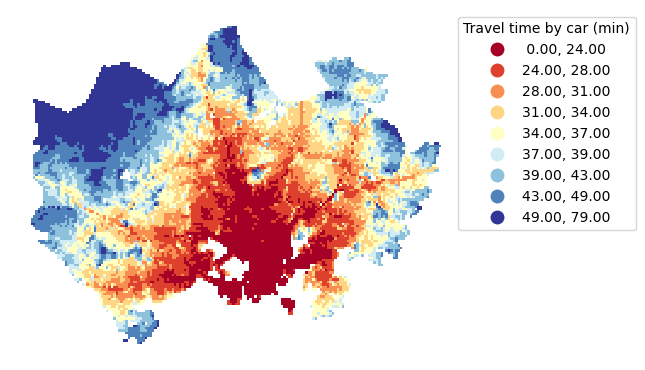

In [21]:
# Solution

# Create one subplot. Control figure size in here.
fig, ax = plt.subplots(figsize=(6, 4))

# Visualize the travel times into 9 classes using "Quantiles" classification scheme
grid.plot(
    ax=ax,
    column="car_r_t",
    cmap="RdYlBu",
    linewidth=0,
    scheme="Quantiles",
    k=9,
    legend=True,
)

# Re-position the legend and set a title
ax.get_legend().set_bbox_to_anchor((1.4, 1))
ax.get_legend().set_title("Travel time by car (min)")

# Set the x and y axis off and adjust padding around the subplot
plt.axis("off")
plt.tight_layout()

# Save the figure as png file with resolution of 300 dpi
outfp = "static_map2.png"
plt.savefig(outfp, dpi=300)

## User defined classification scheme

One intuitive way to display travel time data is to visualize the increasing travel time in fixed intervals, for example changing the color at each 10 minute interval.

In [22]:
break_values = [10, 20, 30, 40, 50, 60, 70, 80, 90]
classifier = mapclassify.UserDefined(y=travel_times, bins=break_values)
classifier

UserDefined

    Interval       Count
------------------------
[  0.00,  10.00] |    49
( 10.00,  20.00] |   286
( 20.00,  30.00] |  1071
( 30.00,  40.00] |  2678
( 40.00,  50.00] |  2697
( 50.00,  60.00] |  2125
( 60.00,  70.00] |  1631
( 70.00,  80.00] |  1109
( 80.00,  90.00] |   603
( 90.00, 181.00] |   771

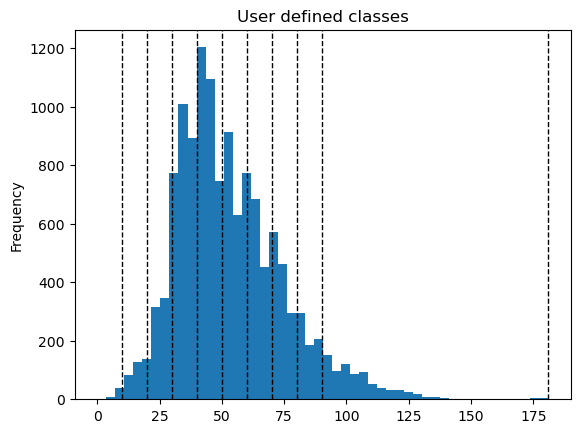

In [23]:
import matplotlib.pyplot as plt

# Define classifier
classifier = classifier = mapclassify.UserDefined(y=travel_times, bins=break_values)

# Plot histogram for public transport rush hour travel time
grid["pt_r_t"].plot.hist(bins=50, title="User defined classes")

# Add vertical lines for class breaks
for break_point in classifier.bins:
    plt.axvline(break_point, color="k", linestyle="dashed", linewidth=1)

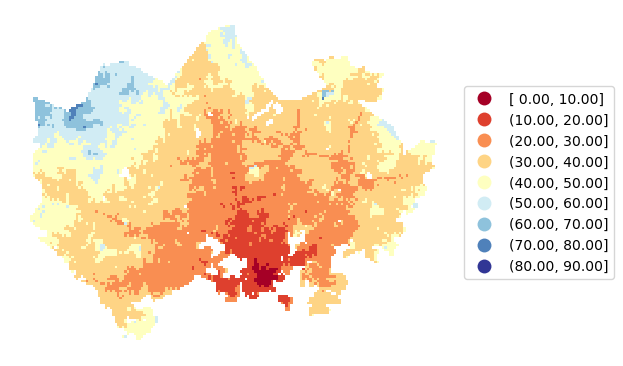

In [24]:
# Create one subplot. Control figure size in here.
fig, ax = plt.subplots(figsize=(6, 4))


# Visualize the travel times into 9 classes using "Quantiles" classification scheme
grid.plot(
    ax=ax,
    column="car_r_t",
    cmap="RdYlBu",
    linewidth=0,
    scheme="UserDefined",
    classification_kwds={'bins': break_values},
    legend=True,
    legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5), "interval": True}
)

# Set the x and y axis off and adjust padding around the subplot
plt.axis("off")
plt.tight_layout()

## Adding a basemap

Let's now forget about separate transport network layers we used previously and add spatial context using basemaps from online sources. Basemaps might feature satellite imagery or a readily visualized bacground maps displaying various essential features such as streets, administrative boundaries, water bodies and so on.  We can use [contextily](https://github.com/darribas/contextily) together with `geopandas` and `matplotlib` to fetch map tiles as basemaps for our static maps. Bacground maps are available via `contextily` from various providers: 

In [25]:
print(list(ctx.providers))

['OpenStreetMap', 'MapTilesAPI', 'OpenSeaMap', 'OPNVKarte', 'OpenTopoMap', 'OpenRailwayMap', 'OpenFireMap', 'SafeCast', 'Stadia', 'Thunderforest', 'BaseMapDE', 'CyclOSM', 'Jawg', 'MapBox', 'MapTiler', 'TomTom', 'Esri', 'OpenWeatherMap', 'HERE', 'HEREv3', 'FreeMapSK', 'MtbMap', 'CartoDB', 'HikeBike', 'BasemapAT', 'nlmaps', 'NASAGIBS', 'NLS', 'JusticeMap', 'GeoportailFrance', 'OneMapSG', 'USGS', 'WaymarkedTrails', 'OpenAIP', 'OpenSnowMap', 'AzureMaps', 'SwissFederalGeoportal', 'TopPlusOpen', 'Gaode', 'Strava', 'OrdnanceSurvey']


For most of the providers, there are multiple style options available. Here is an example for available OpenStreetMap visualizations: 


In [26]:
ctx.providers.OpenStreetMap.keys()

dict_keys(['Mapnik', 'DE', 'CH', 'France', 'HOT', 'BZH', 'BlackAndWhite'])

Map tiles are typically distributed in [Web Mercator projection (EPSG:3857)](http://spatialreference.org/ref/sr-org/epsg3857-wgs84-web-mercator-auxiliary-sphere/). We either need to re-project our data before plotting, or set the desired coordinate reference system directly when adding the basemap using contextily. Let's plot our data using `geopandas` and add a default basemap for our plot using `contextily` using in the local EPSG:3067 projection:

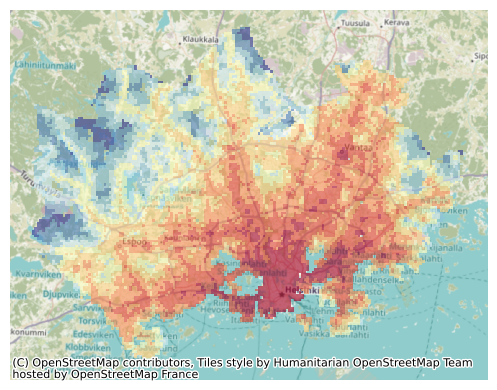

In [27]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the data
grid.plot(
    ax=ax,
    column="pt_r_t",
    cmap="RdYlBu",
    linewidth=0,
    scheme="Natural_Breaks",
    k=9,
    alpha=0.6,
)

# Set axis off (remove the frame and labels from x and y axis)
plt.axis("off")

# Remove the empty white-space around the axes
plt.tight_layout()

# Add basemap and set crs
ctx.add_basemap(ax, crs=grid.crs)

We can change the background map easily using the `source` -parameter when adding the basemap:

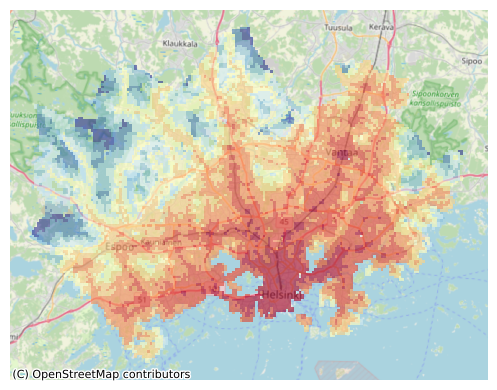

In [28]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the data
grid.plot(
    ax=ax,
    column="pt_r_t",
    cmap="RdYlBu",
    linewidth=0,
    scheme="Natural_Breaks",
    k=9,
    alpha=0.6,
)

# Set axis off (remove the frame and labels from x and y axis)
plt.axis("off")

# Remove the empty white-space around the axes
plt.tight_layout()

# Add basemap with basic OpenStreetMap visualization
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=grid.crs)

 Let's take a subset of our data to see a bit better the background map characteristics:

C:\Hyapp\Miniconda3\envs\python-gis-book\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


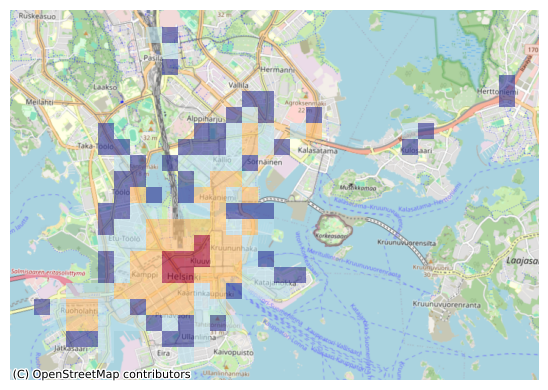

In [29]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(6, 4))

# Subset the data to seel only grid squares near the destination
subset = grid.loc[(grid["pt_r_t"] >= 0) & (grid["pt_r_t"] <= 15)].copy()

# Plot the data from subset
subset.plot(
    ax=ax,
    column="pt_r_t",
    cmap="RdYlBu",
    linewidth=0,
    scheme="Natural_Breaks",
    k=4,
    alpha=0.6,
)

# Set axis off (remove the frame and labels from x and y axis)
plt.axis("off")

# Remove the empty white-space around the axes
plt.tight_layout()

# Add basemap with `OSM_A` style
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=grid.crs)

Now our map has much more details as the zoom level of the background map is larger. `Contextily` sets the zoom level automatically but it is also possible to control the zoom level manually. The zoom level is by default specified as `auto` and it can be changed by passing in a specified [zoom level](https://wiki.openstreetmap.org/wiki/Zoom_levels) as numbers ranging typically from 1 to 19 (the larger the number, the more details your basemap will have). Let's try reducing the level of detail from our map by passing `zoom=11`:


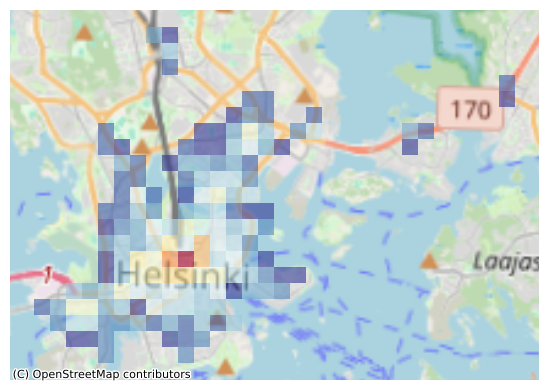

In [30]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the data from subset
subset.plot(ax=ax, column="pt_r_t", cmap="RdYlBu", linewidth=0, alpha=0.6)

# Set axis off (remove the frame and labels from x and y axis)
plt.axis("off")

# Remove the empty white-space around the axes
plt.tight_layout()

# Add basemap with `OSM_A` style using zoom level of 11
ctx.add_basemap(ax, zoom=11, source=ctx.providers.OpenStreetMap.Mapnik, crs=grid.crs)

With this zoom setting, the map has now less detail (a bit too blurry for such a small area). 

As you can see, `contextily` automatically adds credits for the bacground map. We can modify the credits text and add attribution also to the travel time data (Tenkanen & Toivonen 2020) in addition to the credits to OpenStreetMap contributors.

In [31]:
credits = "Travel time data by Tenkanen & Toivonen (2020), Map Data © OpenStreetMap contributors"

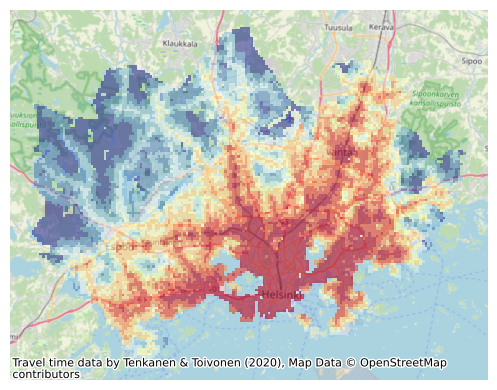

In [32]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the data
grid.plot(
    ax=ax,
    column="pt_r_t",
    cmap="RdYlBu",
    linewidth=0,
    scheme="quantiles",
    k=9,
    alpha=0.6,
)

# Set axis off (remove the frame and labels from x and y axis)
plt.axis("off")

# Remove the empty white-space around the axes
plt.tight_layout()

# Add basemap with `OSM_A` style using zoom level of 11
# Modify the attribution
ctx.add_basemap(
    ax, attribution=credits, source=ctx.providers.OpenStreetMap.Mapnik, crs=grid.crs
)

It is also possible to use many other map tiles from different [Tile Map Services](https://en.m.wikipedia.org/wiki/Tile_Map_Service) as the background map. A good list of different available sources can be found from in [leaflet-providers](http://leaflet-extras.github.io/leaflet-providers/preview/). When using map tiles from different sources, it is necessary to parse a url address to the tile provider following a format defined by the provider. 

Next, we will see how to use map tiles provided by CartoDB. To do that we need to parse the url address following their [definition](https://github.com/CartoDB/basemap-styles#1-web-raster-basemaps) `'https://{s}.basemaps.cartocdn.com/{style}/{z}/{x}/{y}{scale}.png'` where:

 - {s}: one of the available subdomains, either [a,b,c,d]
 - {z} : Zoom level. We support from 0 to 20 zoom levels in OSM tiling system.
 - {x},{y}: Tile coordinates in OSM tiling system
 - {scale}: OPTIONAL "@2x" for double resolution tiles
 - {style}: Map style, possible value is one of:
 
    - light_all,
    - dark_all,
    - light_nolabels,
    - light_only_labels,
    - dark_nolabels,
    - dark_only_labels,
    - rastertiles/voyager,
    - rastertiles/voyager_nolabels,
    - rastertiles/voyager_only_labels,
    - rastertiles/voyager_labels_under
    
We will use this information to parse the parameters in a way that contextily wants them:

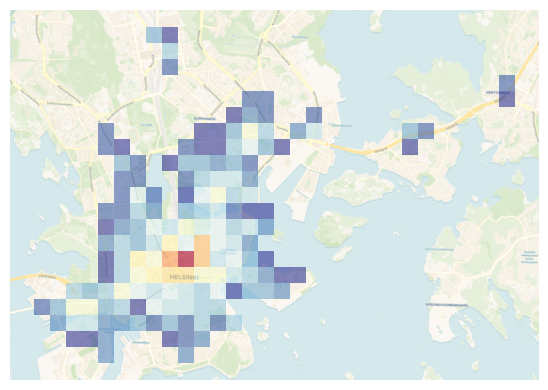

In [33]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(6, 4))

# The formatting should follow: 'https://{s}.basemaps.cartocdn.com/{style}/{z}/{x}/{y}{scale}.png'
# Specify the style to use
style = "rastertiles/voyager"
cartodb_url = "https://a.basemaps.cartocdn.com/%s/{z}/{x}/{y}.png" % style

# Plot the data from subset
subset.plot(ax=ax, column="pt_r_t", cmap="RdYlBu", linewidth=0, alpha=0.6)

# Add basemap with `OSM_A` style using zoom level of 14
ctx.add_basemap(ax, zoom=14, source=cartodb_url, crs=grid.crs)

# Set axis off (remove the frame and labels from x and y axis)
plt.axis("off")

# Remove the empty white-space around the axes
plt.tight_layout()

# Crop the figure
# ax.set_xlim(2770000, 2785000)
# .set_ylim(8435000, 8442500)

As we can see now we have yet again different kind of background map, now coming from CartoDB. 

#### Question 8.2

Plot the grid data using CartoDB style `'dark_all'` as basemap.


In [34]:
# Use this cell to enter your solution.

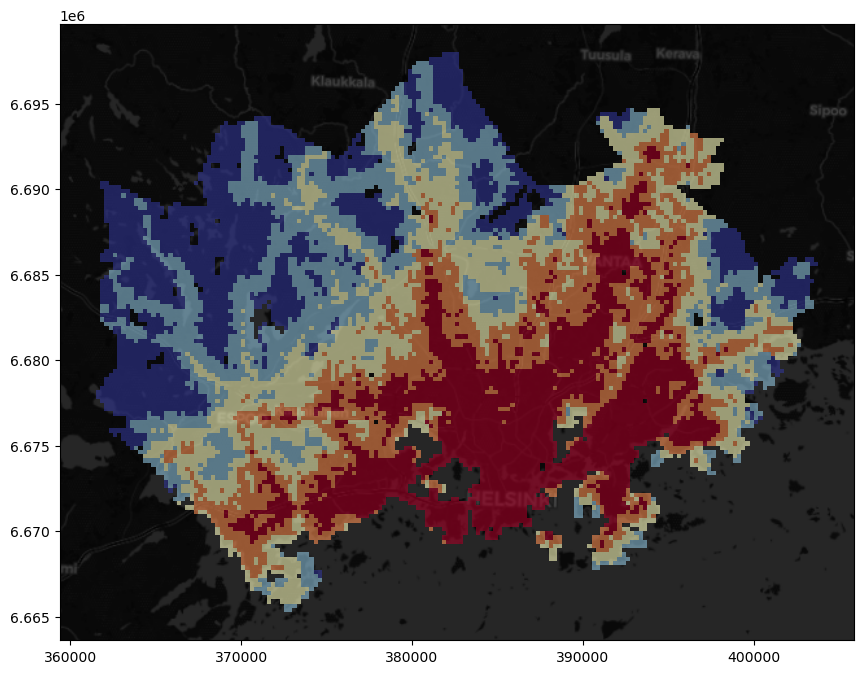

In [35]:
# Solution

# Control figure size in here
fig, ax = plt.subplots(figsize=(12, 8))

# The formatting should follow: 'https://{s}.basemaps.cartocdn.com/{style}/{z}/{x}/{y}{r}.png'
# Specify the style to use
style = "dark_all"
cartodb_url = "https://a.basemaps.cartocdn.com/%s/{z}/{x}/{y}.png" % style

# Plot the data from subset
grid.plot(
    ax=ax,
    column="pt_r_t",
    cmap="RdYlBu",
    linewidth=0,
    scheme="quantiles",
    k=5,
    alpha=0.6,
)

# Add basemap with `OSM_A` style using zoom level of 14
ctx.add_basemap(ax, source=cartodb_url, crs=grid.crs)

## Footnotes
[^geopandas_mappingtools]: <https://geopandas.org/en/stable/docs/user_guide/mapping.html> 
[^matplotlib_pyplot]: <https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html> 
[^HSL_opendata]: <https://www.avoindata.fi/data/en_GB/dataset/hsl-n-linjat>
[^matplotlib_colormaps]: <https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html#choosing-colormaps-in-matplotlib>
[^matplotlib_legend]: <https://matplotlib.org/tutorials/intermediate/legend_guide.html>
[^matplotlib_colors]: <https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.colors>
[^mapclassify]: <https://pysal.org/mapclassify/>